# Module 1 - Data Load / Display / Normalization

In this module you will learn how to load a nifti image utilizing  nibabel and create datasets that can be used with machine learning algorithms. The basic features we will consider are intensity based and originate from multiple acquisition types. 

### Step 1: Load basic python libraries 

In [2]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import csv
from pandas.tools.plotting import scatter_matrix
from sklearn import preprocessing
import nibabel as nib

/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Step 2: Load the three types of images available. 

- T1w pre-contrast
- FLAIR 
- T1w post-contrast 

The goal is to  create a 4D image that contains all four 3D volumes we will use in our example

In [3]:
CurrentDir= os.getcwd()

# Print current directory
print (CurrentDir)
# Get parent direcotry 
print(os.path.abspath(os.path.join(CurrentDir, os.pardir)))

# Create the file paths. The images are contained in a subfolder called Data. 
PostName =  os.path.abspath(os.path.join(os.path.abspath(os.path.join(CurrentDir, os.pardir)), "Data",  'POST.nii.gz')  )
PreName =  os.path.abspath(os.path.join(os.path.abspath(os.path.join(CurrentDir, os.pardir)), "Data", 'PRE.nii.gz') )
FLAIRName =  os.path.abspath(os.path.join(os.path.abspath(os.path.join(CurrentDir, os.pardir)), "Data", 'FLAIR.nii.gz') )
GroundTruth=  os.path.abspath(os.path.join(os.path.abspath(os.path.join(CurrentDir, os.pardir)), "Data", 'GroundTruth.nii.gz') )

# read Pre in--we assume that all images are same x,y dims
Pre = nib.load(PreName)
# Pre is a class containing the image data among other information 
Pre=Pre.get_data()
xdim = np.shape(Pre)[0]
ydim = np.shape(Pre)[1]
zdim = np.shape(Pre)[2]
# Printing the dimensions of an image 
print ('Dimensions')
print (xdim,ydim,zdim)
# Normalize to mean
Pre=Pre/np.mean(Pre[np.nonzero(Pre)])
# Post
Post = nib.load(PostName)
Post=Post.get_data()
# Normalize to mean
Post=Post/np.mean(Post[np.nonzero(Post)])
Flair = nib.load(FLAIRName)
Flair=Flair.get_data()
# Normalize FLAIR 
Flair=Flair/np.mean(Flair[np.nonzero(Flair)])
print ("Data Loaded")

/home/sara/Medical/MachineLearningForMedicalImages-master/notebooks
/home/sara/Medical/MachineLearningForMedicalImages-master
Dimensions
240 240 155
Data Loaded


### Create traing set

We assume the following labels. 

> Enhancing Tumor = 4

> Edema = 2

> WM and CSF and GM=1

> Background (air) = 0
    

In [4]:
#  Load Ground Truth
GroundTrutha = nib.load(GroundTruth)
GroundTruth=GroundTrutha.get_data()
print ("Data Loaded")

Data Loaded


#### Plot the images 

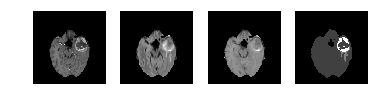

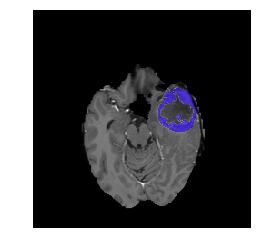

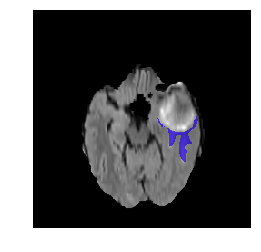

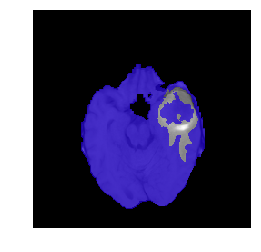

In [5]:
def display_overlay(Image1, Image2):
    """
    Function: Overlays Image2 over Image1
    Image 1: 2D image
    Image 2: 2D Image

    Requires numpy, matplotlib
    """
    Image1=np.rot90(Image1,3)
    Image2=np.rot90(Image2,3)
    Image2 = np.ma.masked_where(Image2 == 0, Image2)
    plt.imshow(Image1, cmap=plt.cm.gray)
    plt.imshow(Image2, cmap=plt.cm.brg, alpha=.7, vmin=.7, vmax=5, interpolation='nearest')
    plt.axis('off')
    plt.show()

f, (ax1,ax2,ax3,ax4)=plt.subplots(1,4)
ax1.imshow(np.rot90(Post[:, :, 55,],3), cmap=plt.cm.gray)
ax1.axis('off')
ax2.imshow(np.rot90(Flair[:, :, 55,],3), cmap=plt.cm.gray)
ax2.axis('off')
ax3.imshow(np.rot90(Pre[:, :, 55,],3), cmap=plt.cm.gray)
ax3.axis('off')
ax4.imshow(np.rot90(GroundTruth[:, :, 55,],3), cmap=plt.cm.gray)
ax4.axis('off')

plt.show()

display_overlay(Post[:, :, 55,], GroundTruth[:,:,55]==4)  
display_overlay(Flair[:, :, 55,], GroundTruth[:,:,55]==2)  
display_overlay(Pre[:, :, 55,], GroundTruth[:,:,55]==1)    

### Create dataset

In [6]:
# Create classes
# Tissue =GM+CSG+WM
ClassTissuePost=(Post[np.nonzero(GroundTruth==1)])
ClassTissuePre=(Pre[np.nonzero(GroundTruth==1)])
ClassTissueFlair=(Flair[np.nonzero(GroundTruth==1)])
# Enhancing Tumor 
ClassTumorPost=(Post[np.nonzero(GroundTruth==4)])
ClassTumorPre=(Pre[np.nonzero(GroundTruth==4)])
ClassTumorFlair=(Flair[np.nonzero(GroundTruth==4)])
# Edema 
ClassEdemaPost=(Post[np.nonzero(GroundTruth==2)])
ClassEdemaPre=(Pre[np.nonzero(GroundTruth==2)])
ClassEdemaFlair=(Flair[np.nonzero(GroundTruth==2)])
# We only select 1000 points for demosntration purposes
IND=np.random.randint(np.shape(ClassTumorPre)[0], size=5000)
ClassTissuePost=ClassTissuePost[IND]
ClassTissuePre=ClassTissuePre[IND]
ClassTissueFlair=ClassTissueFlair[IND]
ClassTumorPost=ClassTumorPost[IND]
ClassTumorPre=ClassTumorPre[IND]
ClassTumorFlair=ClassTumorFlair[IND]
ClassEdemaPost=ClassEdemaPost[IND]
ClassEdemaPre=ClassEdemaPre[IND]
ClassEdemaFlair=ClassEdemaFlair[IND]
print ("Saving the data to a pandas dataframe and subsequently to a csv")
# Create a dictionary containing the classes
datasetcomplete={"ClassTissuePost": ClassTissuePost, "ClassTissuePre": ClassTissuePre, "ClassTissueFlair": ClassTissueFlair, "ClassTumorPost": ClassTumorPost, "ClassTumorPre": ClassTumorPre, "ClassTumorFlair": ClassTumorFlair, "ClassEdemaPost": ClassEdemaPost, "ClassEdemaPre": ClassEdemaPre, "ClassEdemaFlair": ClassEdemaFlair}
datapd=pd.DataFrame.from_dict(datasetcomplete,orient="index")
# print (datapd)
datapd=datapd.transpose()
# datapd=pd.DataFrame(dict([ (k,Series(v)) for k,v in datasetcomplete.iteritems() ]))
datapd.to_csv("DataExample.csv",index=False)

Saving the data to a pandas dataframe and subsequently to a csv


### Create some scatter plots

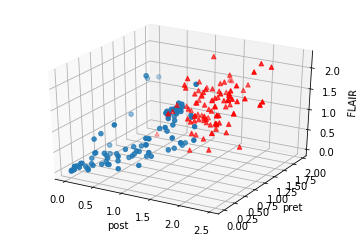

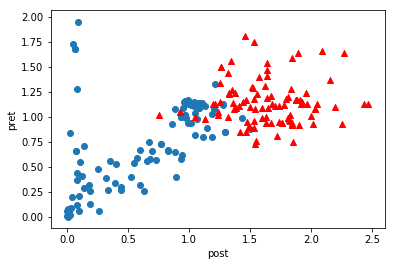

In [7]:
# Display Tumor vs NAWM
IND=np.random.randint(1000, size=100)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ClassTissuePost[IND,], ClassTissuePre[IND,], ClassTissueFlair[IND,])
ax.scatter(ClassTumorPost[IND,], ClassTumorPre[IND,], ClassTumorFlair[IND,], c='r', marker='^')
ax.set_xlabel('post')
ax.set_ylabel('pret')
ax.set_zlabel('FLAIR')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ClassTissuePost[IND,], ClassTissuePre[IND,])
ax.scatter(ClassTumorPost[IND,], ClassTumorPre[IND,], c='r', marker='^')
ax.set_xlabel('post')
ax.set_ylabel('pret')
plt.show()

## Describe the data 

In [9]:
# descriptions
print(datapd.describe())

       ClassTissuePost  ClassTissuePre  ClassTissueFlair  ClassTumorPost  \
count      5000.000000     5000.000000       5000.000000     5000.000000   
mean          0.667596        0.728191          0.589644        1.604269   
std           0.426425        0.408256          0.440849        0.322594   
min           0.000000        0.002493          0.000000        0.402899   
25%           0.187311        0.344399          0.156201        1.380358   
50%           0.836808        0.793455          0.499042        1.595792   
75%           1.025568        1.107893          1.049030        1.823032   
max           2.011594        2.097758          1.815805        2.679785   

       ClassTumorPre  ClassTumorFlair  ClassEdemaPost  ClassEdemaPre  \
count    5000.000000      5000.000000     5000.000000    5000.000000   
mean        1.141381         1.396736        1.022460       1.100306   
std         0.230534         0.375345        0.127461       0.083426   
min         0.270608       